In [1]:
from IPython.display import display, HTML
display(HTML("""
<style>
div.container{width:99% !important;}
div.cell.code_cell.rendered{width:100%;}
div.input_prompt{padding:0px;}
div.CodeMirror {font-family:Consolas; font-size:24pt;}
div.text_cell_render.rendered_html{font-size:20pt;}
div.text_cell_render ul li, code{font-size:22pt; line-height:30px;}
div.output {font-size:24pt; font-weight:bold;}
div.input {font-family:Consolas; font-size:24pt;}
div.prompt {min-width:70px;}
div#toc-wrapper{padding-top:120px;}
div.text_cell_render ul li{font-size:24pt;padding:5px;}
table.dataframe{font-size:24px;}
</style>
"""))

In [9]:
import numpy as np
import pandas as pd
from tensorflow.keras.datasets import mnist # mnist 훈련셋과 테스트셋
from tensorflow.keras.utils import to_categorical # 원핫인코딩
from tensorflow.keras.models import Sequential, save_model, load_model
from tensorflow.keras.layers import Dense, Input, Dropout
from tensorflow.keras.layers import LeakyReLU, ELU, ReLU
from matplotlib import pyplot as plt # 학습과정 시각화
# scale 조정, train_test_split 등을 추가

In [10]:
# mnist데이터 일부를 이미지 출력하기
(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_test.shape, y_test.shape

((10000, 28, 28), (10000,))

In [11]:
y_test[:30]

array([7, 2, 1, 0, 4, 1, 4, 9, 5, 9, 0, 6, 9, 0, 1, 5, 9, 7, 3, 4, 9, 6,
       6, 5, 4, 0, 7, 4, 0, 1], dtype=uint8)

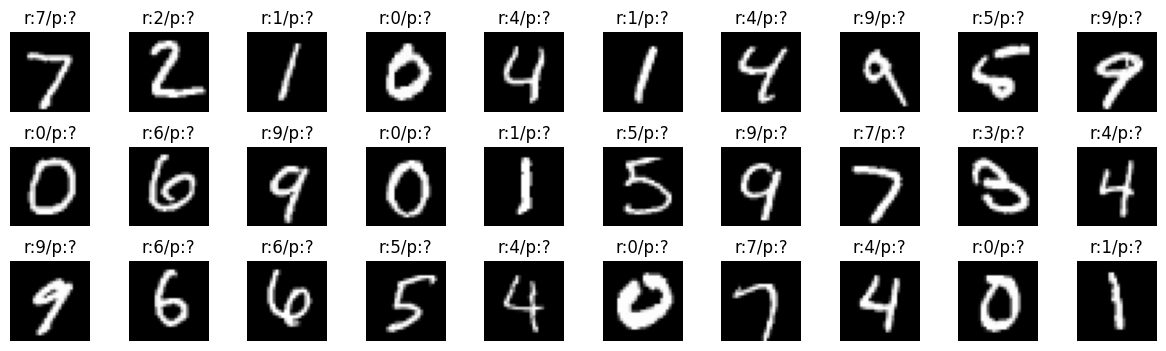

In [26]:
plt_row = 3
plt_col = 10
# plt.figure(figsize=(plt_col,plt_row))
plt.rcParams['figure.figsize'] = (plt_col*1.2, plt_row*1.2)
fig, axarr = plt.subplots(nrows=plt_row, ncols=plt_col)
# plt.subplots_adjust(hspace=0.4, wspace=0.3)
# axarr[1,1].imshow(X_test[11], cmap='grey')
# axarr[1,1].axis('off')
# axarr[1,1].set_title(f'real:{y_test[11]}')
for i in range(plt_row*plt_col):
    ax = axarr[i//plt_col, i%plt_col]
    ax.imshow(X_test[i], cmap='gray')
    ax.axis('off')
    ax.set_title(f'r:{y_test[i]}/p:?')
plt.tight_layout()

# 1. DNN

In [33]:
%%time
(X_train, y_train), (X_test, y_test) = mnist.load_data()
# Train데이터 6만개 => Train(5만개) + val(만개)로 분리
X_val = X_train[50000:]
y_val = y_train[50000:]
X_train = X_train[:50000]
y_train = y_train[:50000]
# 입력(독립) 변수 (n, 28, 28) -> (n, 28*28) -> 실수형변환 -> 스케일조정(/255.0)
train_X = X_train.reshape(50000, 28*28).astype('float32')/255.0
val_X   = X_val.reshape(-1, 784).astype('float32')/255.0
test_X  = X_test.reshape(10000, -1).astype('float32')/255.0
# 분류분석을 위한 타겟변수의 원핫인코딩
train_Y = to_categorical(y_train, 10) # 10:카테고리수(안쓰면 자동 입력)
val_Y   = to_categorical(y_val)
test_Y  = to_categorical(y_test)
# 모델
model = Sequential()
model.add(Input(shape=(784,)))
model.add(Dense(units=1024, activation='relu')) # activation='leakyrelu' 사용불가
model.add(Dropout(0.3))
model.add(Dense(units=512, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(units=128, activation='relu'))
model.add(LeakyReLU(alpha=0.01)) # 음수결과에 대해 1%만 통과
model.add(Dropout(0.3))
model.add(Dense(units=10, activation='softmax'))
model.compile(loss='categorical_crossentropy', # sparse_categorical_crossentropy
             optimizer='adam',
             metrics=['accuracy'])# 평가지표

hist = model.fit(train_X, train_Y, # 학습셋
                epochs=20,
                batch_size=100,
                validation_data=(val_X, val_Y),
                verbose=1)

Epoch 1/20
500/500 [==============================] - 4s 8ms/step - loss: 0.3057 - accuracy: 0.9079 - val_loss: 0.1243 - val_accuracy: 0.9611
Epoch 2/20
500/500 [==============================] - 4s 8ms/step - loss: 0.1337 - accuracy: 0.9605 - val_loss: 0.0847 - val_accuracy: 0.9745
Epoch 3/20
500/500 [==============================] - 4s 8ms/step - loss: 0.0965 - accuracy: 0.9712 - val_loss: 0.0955 - val_accuracy: 0.9721
Epoch 4/20
500/500 [==============================] - 4s 8ms/step - loss: 0.0807 - accuracy: 0.9756 - val_loss: 0.0855 - val_accuracy: 0.9741
Epoch 5/20
500/500 [==============================] - 4s 8ms/step - loss: 0.0691 - accuracy: 0.9797 - val_loss: 0.0877 - val_accuracy: 0.9761
Epoch 6/20
500/500 [==============================] - 4s 8ms/step - loss: 0.0586 - accuracy: 0.9829 - val_loss: 0.0780 - val_accuracy: 0.9777
Epoch 7/20
500/500 [==============================] - 4s 8ms/step - loss: 0.0526 - accuracy: 0.9841 - val_loss: 0.0855 - val_accuracy: 0.9761
Epoch 

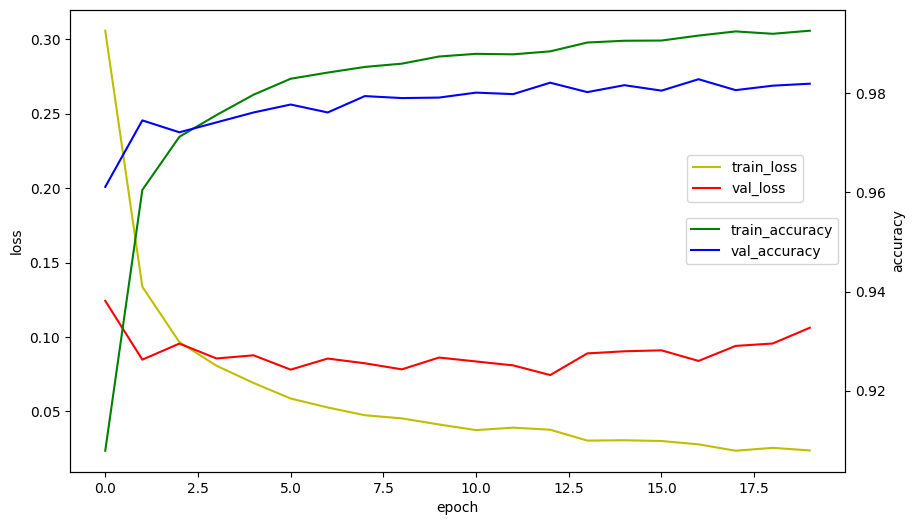

In [34]:
# 학습과정 표시하기
import matplotlib.pyplot as plt
fig, loss_ax = plt.subplots(figsize=(10,6))
loss_ax.plot(hist.history['loss'], 'y', label='train_loss')
loss_ax.plot(hist.history['val_loss'], 'r', label='val_loss')
acc_ax = loss_ax.twinx() # loss_ax와 x축을 공유하는 acc_ax 생성
acc_ax.plot(hist.history['accuracy'], 'g', label='train_accuracy')
acc_ax.plot(hist.history['val_accuracy'], 'b', label='val_accuracy')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuracy')
loss_ax.legend(bbox_to_anchor=(0.955, 0.7))
acc_ax.legend(loc='center right')
plt.show()

In [36]:
# 모델 평가
loss, acc = model.evaluate(test_X, test_Y, verbose=0)
acc

0.9817000031471252

In [38]:
# 틀린갯수
len(test_Y)-len(test_Y)*acc

182.99996852874756

In [39]:
test_Y

array([[0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [40]:
# 틀린 이미지만 출력하기 위해, 실제값과 예측값
# 실제값들
real=test_Y.argmax(axis=1)
real=np.argmax(test_Y, axis=1)
y_test

In [42]:
np.all(test_Y.argmax(axis=1) == y_test)

True

In [45]:
# 예측값
y_hat=model.predict(test_X, verbose=0).argmax(axis=1)

In [46]:
y_test.shape, y_hat.shape # 실제값과 예측값

((10000,), (10000,))

In [47]:
# 성능 교차표(교차표, 혼동행렬)
pd.crosstab(y_test, y_hat)

col_0,0,1,2,3,4,5,6,7,8,9
row_0,,,,,,,,,,
0,968,1,0,0,1,0,4,1,3,2
1,0,1124,2,0,0,0,1,0,8,0
2,1,0,1017,0,1,0,0,9,4,0
3,0,0,2,993,0,3,0,7,3,2
4,1,2,2,0,961,0,4,2,1,9
5,3,0,1,5,2,869,6,2,3,1
6,1,4,0,1,2,3,943,0,4,0
7,0,3,5,0,1,0,0,1013,2,4
8,1,0,1,4,3,5,2,5,952,1


In [49]:
plt_row = 19
plt_col = 10
i = 0 # y_hat과 y_test를 액세스할 index:0 ~ 9999
cnt = 0 # 이미지 출력 횟수 : 1~120
while (cnt<plt_row*plt_col) & (i<len(y_test)):
    if(y_test[i]==y_hat[i]):
        i += 1
        continue
    title = f'r:{y_test[i]}/p:{y_hat[i]}'
    print(title, end='\t')
    i += 1
    cnt += 1

r:5/p:6	r:4/p:2	r:2/p:7	r:5/p:3	r:3/p:7	r:6/p:0	r:4/p:9	r:9/p:8	r:8/p:0	r:1/p:8	r:5/p:8	r:4/p:9	r:8/p:7	r:9/p:7	r:2/p:7	r:8/p:9	r:5/p:4	r:1/p:2	r:6/p:5	r:7/p:2	r:4/p:6	r:7/p:8	r:6/p:1	r:6/p:5	r:7/p:2	r:9/p:8	r:4/p:9	r:9/p:5	r:7/p:1	r:5/p:7	r:8/p:3	r:7/p:9	r:5/p:8	r:5/p:3	r:8/p:4	r:7/p:9	r:8/p:7	r:4/p:6	r:9/p:3	r:9/p:8	r:0/p:6	r:3/p:7	r:2/p:8	r:8/p:7	r:8/p:3	r:9/p:4	r:0/p:9	r:2/p:7	r:4/p:9	r:7/p:9	r:5/p:6	r:3/p:7	r:6/p:1	r:9/p:2	r:4/p:9	r:6/p:1	r:9/p:6	r:2/p:7	r:5/p:4	r:9/p:1	r:9/p:4	r:3/p:7	r:2/p:4	r:5/p:3	r:9/p:0	r:6/p:1	r:0/p:8	r:4/p:7	r:3/p:8	r:9/p:7	r:3/p:5	r:6/p:8	r:8/p:5	r:6/p:8	r:1/p:2	r:5/p:9	r:0/p:9	r:5/p:7	r:7/p:9	r:3/p:7	r:9/p:1	r:6/p:4	r:3/p:2	r:5/p:0	r:8/p:5	r:9/p:3	r:4/p:6	r:7/p:8	r:0/p:4	r:9/p:4	r:5/p:8	r:5/p:6	r:4/p:6	r:3/p:5	r:7/p:1	r:9/p:4	r:9/p:4	r:7/p:1	r:0/p:8	r:8/p:3	r:9/p:8	r:8/p:2	r:9/p:0	r:2/p:7	r:9/p:7	r:2/p:8	r:5/p:3	r:2/p:7	r:9/p:4	r:4/p:9	r:8/p:7	r:9/p:1	r:6/p:5	r:4/p:9	r:8/p:4	r:6/p:8	r:8/p:3	r:9/p:8	r:9/p:4	r:8/p:6	r:0/p:8	r:8/p:4	r:7/p:4	r:4/p:1	r:1/p:6	

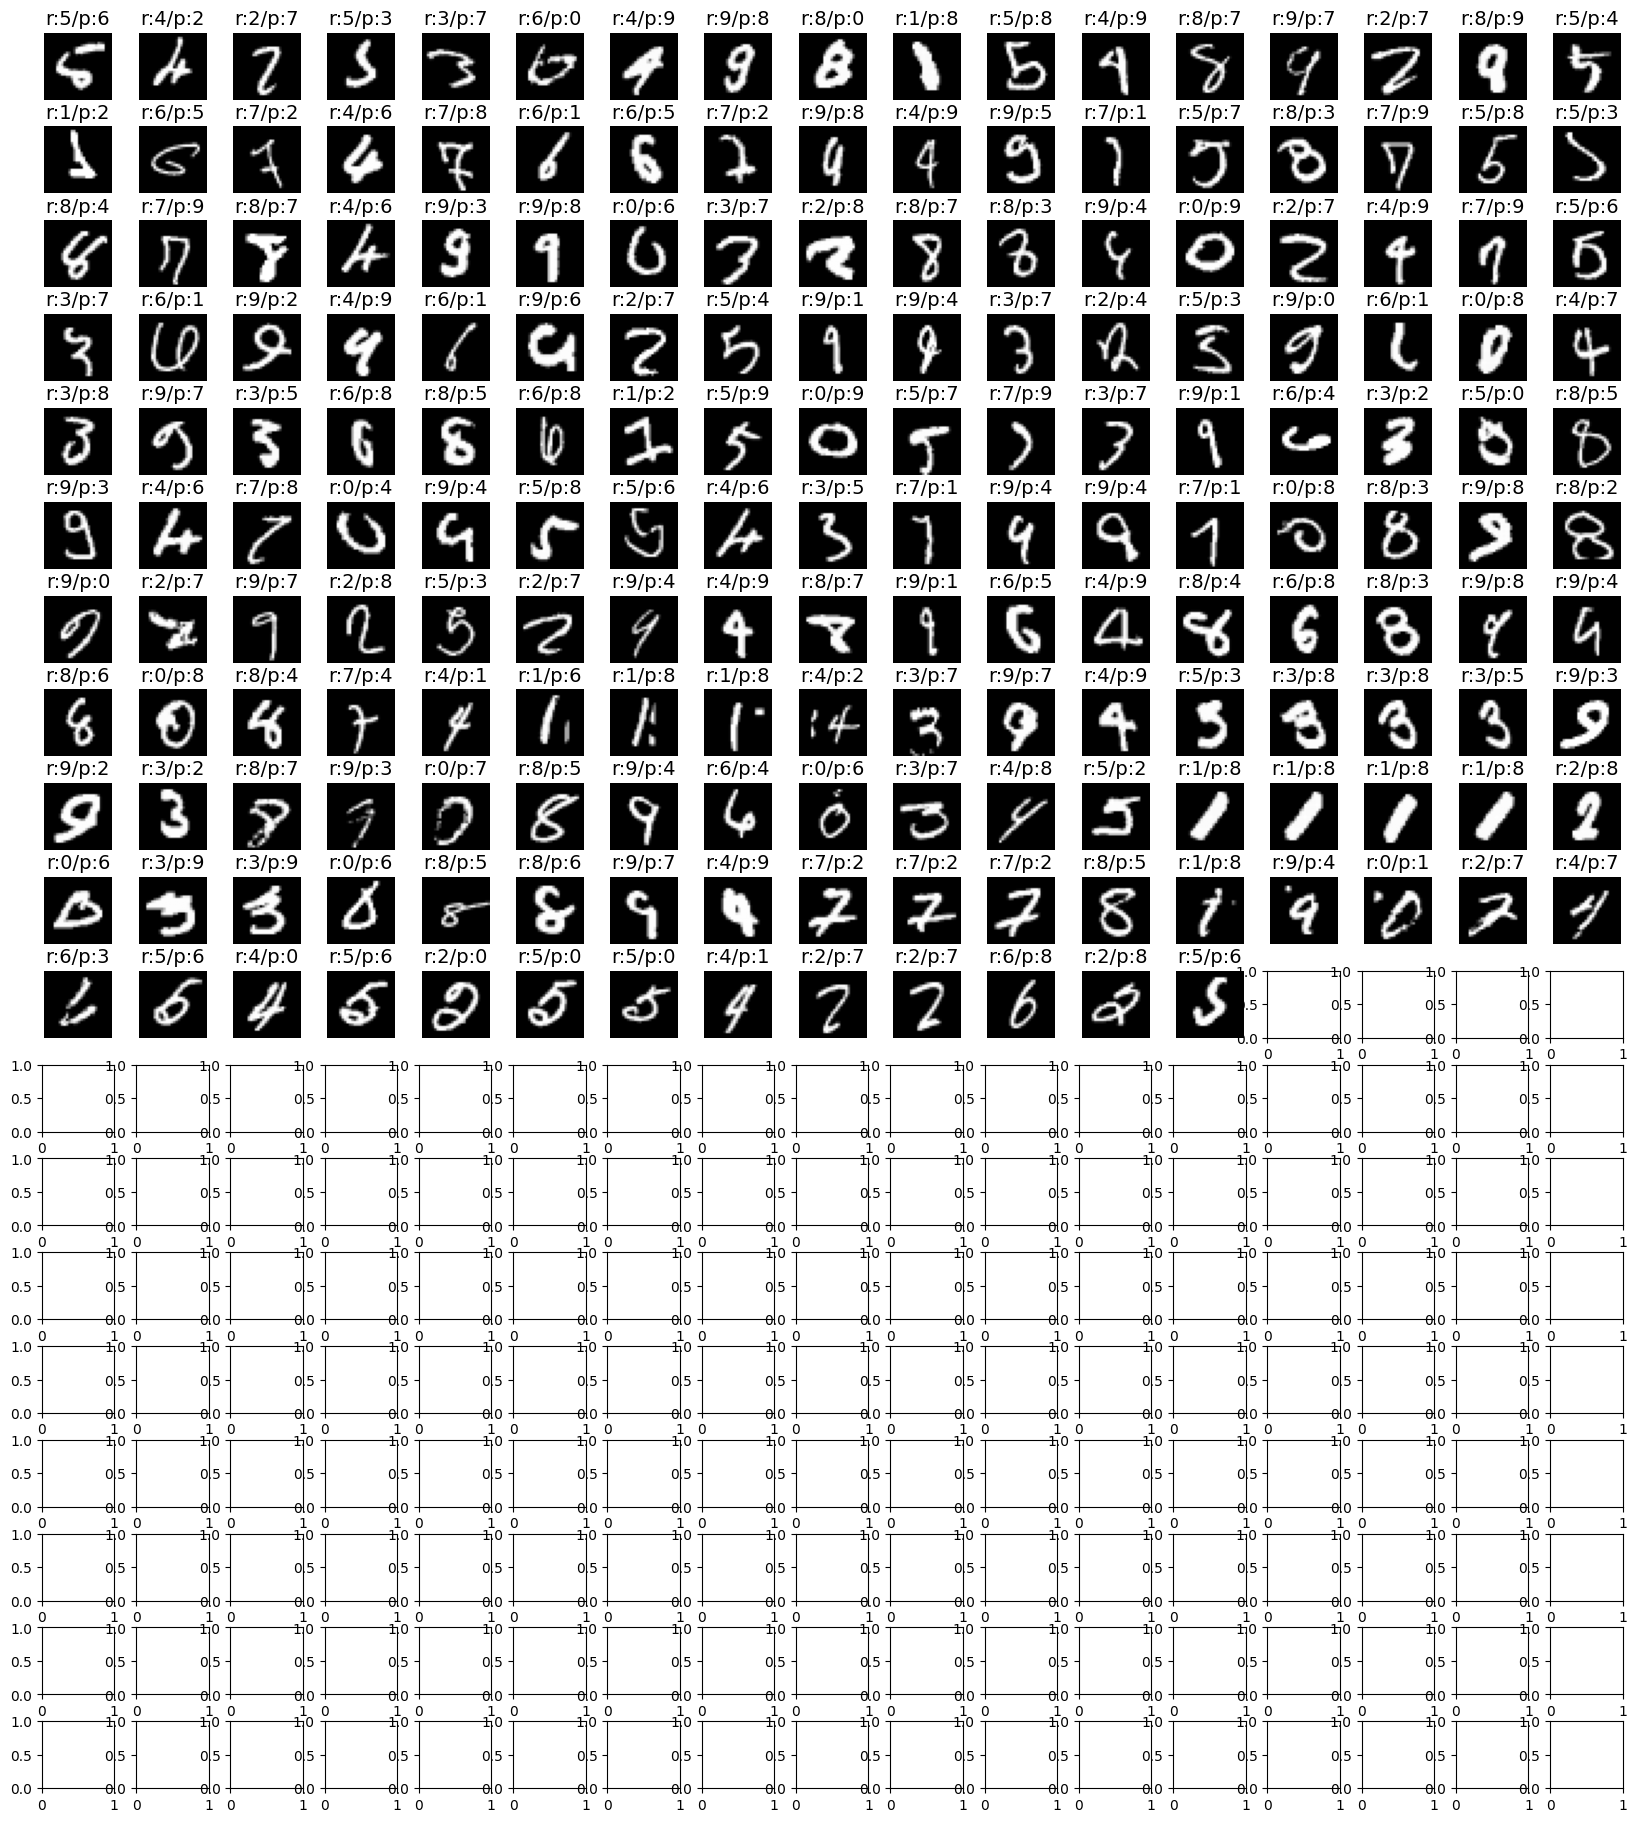

In [51]:
plt_row = 19
plt_col = 17
# plt.figure(figsize=(plt_col,plt_row))
plt.rcParams['figure.figsize'] = (plt_col*1.2, plt_row*1.2)
fig, axarr = plt.subplots(nrows=plt_row, ncols=plt_col)
plt.subplots_adjust(hspace=0.4, wspace=0.3)
i = 0 # y_hat과 y_test를 액세스할 index:0 ~ 9999
cnt = 0 # 이미지 출력 횟수 : 1~120
while (cnt<plt_row*plt_col) & (i<len(y_test)):
    if(y_test[i]==y_hat[i]):
        i += 1
        continue
    title = f'r:{y_test[i]}/p:{y_hat[i]}'
    ax = axarr[cnt//plt_col, cnt%plt_col]
    ax.imshow(X_test[i], cmap='gray')
    ax.axis('off')
    ax.set_title(title, fontsize=14)
    i += 1
    cnt += 1
    

 # 2. CNN 
- 컨볼루션 layer -> pooling -> 컨볼루션 layer -> pooling -> Flatten -> DNN

In [64]:
import numpy as np
import pandas as pd
from tensorflow.keras.datasets import mnist # mnist 훈련셋과 테스트셋
from tensorflow.keras.utils import to_categorical # 원핫인코딩
from tensorflow.keras.models import Sequential, save_model, load_model
from tensorflow.keras.layers import Dense, Input, Dropout
from tensorflow.keras.layers import LeakyReLU, ELU, ReLU

from sklearn.metrics import recall_score, precision_score, accuracy_score
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
# CNN
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [58]:
width=28; height=28
model = Sequential([
            Conv2D(filters=32, # 필터수
                   kernel_size=3, # 필터 사이즈 3x3
                   padding='same', # zero-padding / padding='valid'기본값
                   input_shape = (width, height, 1), # 흑백1채널
                   activation='relu'
                  ), # 28*28 1채널 이미지를 32개 필터로 특성맵 추출=> 28*28*32특성맵
                MaxPool2D(pool_size=(2,2)), # 가로 2배, 세로 2배 전체 4배 줄어듦
                Dropout(0.1), 
                Conv2D(filters=64, kernel_size=(3,3), activation='relu'),
                MaxPool2D(pool_size=(2,2)),
                Dropout(0.25),
                Flatten(), # 2304
                Dense(units=128, activation='relu'),
                Dropout(0.4),
                Dense(units=10, activation='softmax')
])
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 28, 28, 32)        320       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 14, 14, 32)       0         
 2D)                                                             
                                                                 
 dropout_8 (Dropout)         (None, 14, 14, 32)        0         
                                                                 
 conv2d_6 (Conv2D)           (None, 12, 12, 64)        18496     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 6, 6, 64)         0         
 2D)                                                             
                                                                 
 dropout_9 (Dropout)         (None, 6, 6, 64)         

In [65]:
%%time
# 1. 데이터 생성 & 전처리
(X_train, y_train), (X_test, y_test) = mnist.load_data()
# Train데이터 6만개 => Train(5만개) + val(만개)로 분리
X_val = X_train[50000:]
y_val = y_train[50000:]
X_train = X_train[:50000]
y_train = y_train[:50000]
train_X = X_train.astype('float32')/255.0
val_X   = X_val.astype('float32')/255.0
test_X  = X_test.astype('float32')/255.0

train_Y = to_categorical(y_train)
val_Y   = to_categorical(y_val)
test_Y  = to_categorical(y_test)
X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

# 2.모델생성
width=28; height=28
model = Sequential()
model.add(Conv2D(32, kernel_size=3, padding='same',
                   input_shape = (width, height, 1), activation='relu'
                  ))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.1))
model.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(units=128, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(units=10, activation='softmax'))
# 3. 학습과정 설정
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
# 4. 학습하기
early_stopping = EarlyStopping(patience=10)
checkpoint = ModelCheckpoint(
                filepath='mnist{epoch:02d}-loss{val_loss:.4f}-val{val_accuracy:.4f}.h5',
                monitor='val_accuracy',
                save_best_only=True,
                mode='max',
                verbose=1
)
hist =model.fit(train_X, train_Y, epochs=50, batch_size=32, 
                validation_data=(val_X,val_Y),
                callbacks=[early_stopping,checkpoint])

Epoch 1/50
1560/1563 [============================>.] - ETA: 0s - loss: 0.2200 - accuracy: 0.9307
Epoch 1: val_accuracy improved from -inf to 0.98410, saving model to mnist01-loss0.0538-val0.9841.h5
1563/1563 [==============================] - 20s 12ms/step - loss: 0.2199 - accuracy: 0.9308 - val_loss: 0.0538 - val_accuracy: 0.9841
Epoch 2/50
1561/1563 [============================>.] - ETA: 0s - loss: 0.0824 - accuracy: 0.9760
Epoch 2: val_accuracy improved from 0.98410 to 0.98990, saving model to mnist02-loss0.0377-val0.9899.h5
1563/1563 [==============================] - 19s 12ms/step - loss: 0.0824 - accuracy: 0.9760 - val_loss: 0.0377 - val_accuracy: 0.9899
Epoch 3/50
1562/1563 [============================>.] - ETA: 0s - loss: 0.0617 - accuracy: 0.9805
Epoch 3: val_accuracy did not improve from 0.98990
1563/1563 [==============================] - 20s 13ms/step - loss: 0.0617 - accuracy: 0.9805 - val_loss: 0.0394 - val_accuracy: 0.9886
Epoch 4/50
1562/1563 [=======================

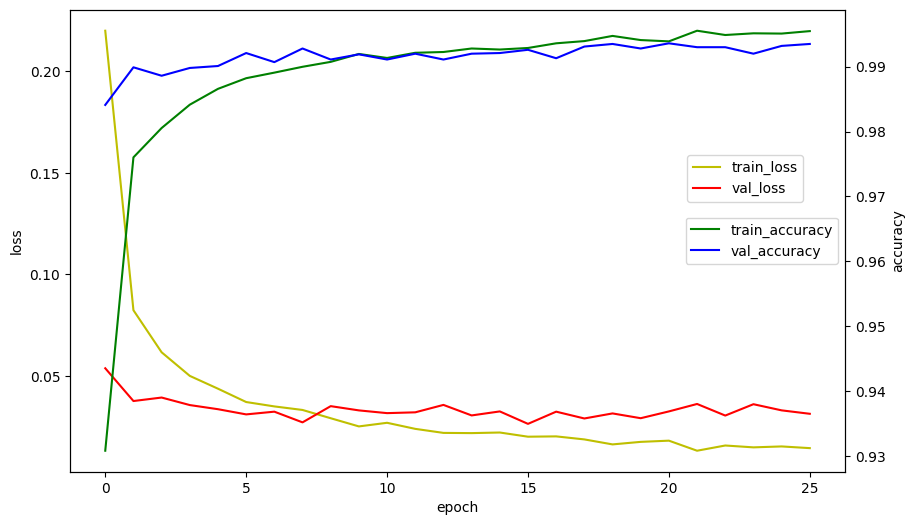

In [66]:
# 학습과정 표시하기
import matplotlib.pyplot as plt
fig, loss_ax = plt.subplots(figsize=(10,6))
loss_ax.plot(hist.history['loss'], 'y', label='train_loss')
loss_ax.plot(hist.history['val_loss'], 'r', label='val_loss')
acc_ax = loss_ax.twinx() # loss_ax와 x축을 공유하는 acc_ax 생성
acc_ax.plot(hist.history['accuracy'], 'g', label='train_accuracy')
acc_ax.plot(hist.history['val_accuracy'], 'b', label='val_accuracy')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuracy')
loss_ax.legend(bbox_to_anchor=(0.955, 0.7))
acc_ax.legend(loc='center right')
plt.show()

In [67]:
# 모델 평가
loss, acc = model.evaluate(test_X, test_Y)
print('최종모델 :', acc, loss)

313/313 [==============================] - 1s 4ms/step - loss: 0.0281 - accuracy: 0.9927
최종모델 : 0.9926999807357788 0.028147336095571518


In [75]:
model1 = load_model('mnist08-loss0.0272-val0.9928.h5')
loss1, acc1 = model1.evaluate(test_X, test_Y, verbose=0)
print('model1 :', acc1, loss1)

model1 : 0.9926000237464905 0.023068111389875412


In [74]:
model2 = load_model('mnist18-loss0.0291-val0.9931.h5')
loss2, acc2 = model2.evaluate(test_X, test_Y, verbose=0)
print('model2 :', acc2, loss2)

model2 : 0.9933000206947327 0.022271549329161644


In [72]:
model3 = load_model('mnist21-loss0.0326-val0.9936.h5')
loss3, acc3 = model3.evaluate(test_X, test_Y, verbose=0)
print('model3 :', acc3, loss3)

model3 : 0.9932000041007996 0.026406152173876762


In [79]:
# 성능평가(성능평가지표= 교차표, 혼동행렬, acc, recall, precision, f1)를 위해 실제값, 예측값
# y_test : 실제값
y_hat=model2.predict(test_X, verbose=0).argmax(axis=1) # 예측값

In [80]:
pd.crosstab(y_test,y_hat)

col_0,0,1,2,3,4,5,6,7,8,9
row_0,,,,,,,,,,
0,977,0,0,0,0,0,1,0,1,1
1,0,1133,0,1,0,1,0,0,0,0
2,1,1,1026,0,0,0,0,4,0,0
3,0,0,1,1006,0,1,0,1,1,0
4,0,1,0,0,978,0,1,0,0,2
5,2,0,0,6,0,883,1,0,0,0
6,4,1,0,0,2,1,948,0,2,0
7,0,2,3,0,0,0,0,1021,1,1
8,0,1,1,0,0,1,0,1,969,1


In [86]:
print('accuracy :', accuracy_score(y_test, y_hat))
# 다중분류의 타겟변수의 균형이 비슷하면 'macro' / 균형이 안 잡힌 데이터면 'weighted'
print('recall :', recall_score(y_test, y_hat, average='weighted'))
print('precision :', precision_score(y_test, y_hat, average='weighted'))
print('f1_score :', f1_score(y_test, y_hat, average='weighted'))

accuracy : 0.9933
recall : 0.9933
precision : 0.9933074701584065
f1_score : 0.9932968319566792


In [88]:
# 틀린갯수
len(y_test)-len(y_test)*acc2

66.99979305267334

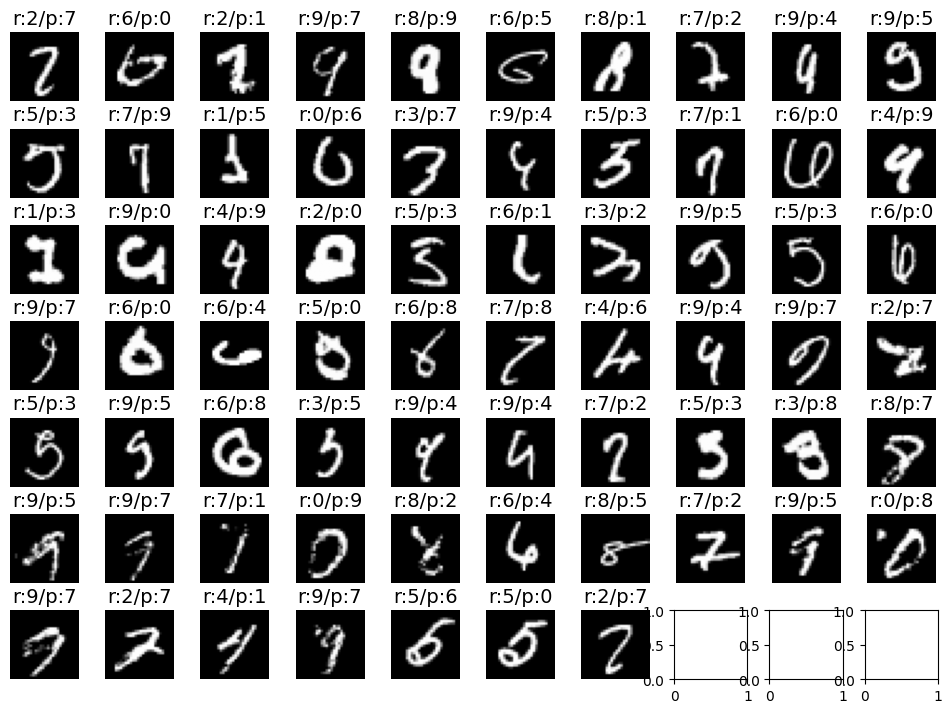

In [96]:
plt_row = 7
plt_col = 10
# plt.figure(figsize=(plt_col,plt_row))
plt.rcParams['figure.figsize'] = (plt_col*1.2, plt_row*1.2)
fig, axarr = plt.subplots(nrows=plt_row, ncols=plt_col)
plt.subplots_adjust(hspace=0.4, wspace=0.3)
i = 0 # y_hat과 y_test를 액세스할 index:0 ~ 9999
cnt = 0 # 이미지 출력 횟수 : 1~120
while (cnt<plt_row*plt_col) & (i<len(y_test)):
    if(y_test[i]==y_hat[i]):
        i += 1
        continue
    title = f'r:{y_test[i]}/p:{y_hat[i]}'
    ax = axarr[cnt//plt_col, cnt%plt_col]
    ax.imshow(X_test[i], cmap='gray')
    ax.axis('off')
    ax.set_title(title, fontsize=14)
    i += 1
    cnt += 1
    